Checking autoencoder
Notebook to test autoencoder.

All you need to input is an example data file and a trained autoencoder model (plus make sure number of features, latent dimensions and batch size are correct). It then encodes your data and decodes it, generating a UMAP to compare raw and decoded data.

In [1]:
import numpy as np
import sys
import torch
import scanpy as sc
import anndata as ad
from torch.utils.data import DataLoader, TensorDataset
from scvi.distributions import NegativeBinomial

from tqdm import tqdm
sys.path.append("/zhome/6a/4/214382/Isoflow")
from utils.autoencoder_utils import NB_Autoencoder, CountsDataset


/zhome/6a/4/214382/venv_2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Model parameters must match training
num_genes = 8573  # for example, pbmc3k
latent_dim = 50
hidden_dims = [512, 256]

model_file = "/dtu/blackhole/0e/214382/datasets/pbmc3k/pbmc3k_train_nb_autoencoder.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = NB_Autoencoder(
    num_features=num_genes,
    latent_dim=latent_dim,
    hidden_dims=hidden_dims
)
model.load_state_dict(torch.load(model_file, map_location=device))
model = model.to(device)
model.eval()  

NB_Autoencoder(
  (hidden_encoder): MLP(
    (net): Sequential(
      (0): Sequential(
        (0): Linear(in_features=8573, out_features=512, bias=True)
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
      (1): Sequential(
        (0): Linear(in_features=512, out_features=256, bias=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
      (2): Linear(in_features=256, out_features=50, bias=True)
    )
  )
  (decoder): MLP(
    (net): Sequential(
      (0): Sequential(
        (0): Linear(in_features=50, out_features=256, bias=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
      (1): Sequential(
        (0): Linear(in_features=256, out_features=512, bias=True)
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_ru

In [3]:
# Load counts for testing
adata_test = ad.read_h5ad("/dtu/blackhole/0e/214382/datasets/pbmc3k/pbmc3k_train.h5ad")
#adata_test = ad.read_h5ad("/dtu/blackhole/06/213542/paperdata/pbmc3k_test.h5ad")
X_test = adata_test.layers["X_counts"]

if hasattr(X_test, "toarray"):
    X_test = X_test.toarray()
X_test = torch.tensor(X_test, dtype=torch.float32)

# Create Dataset / DataLoader
test_dataset = CountsDataset(X_test)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)


/zhome/6a/4/214382/Isoflow/utils/autoencoder_utils.py:196: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)


In [4]:
X_merged = []
labels = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        #size_factor = {"rna": batch["X"]["rna"].sum(1).unsqueeze(1)}
        batch = {k: v.to(device) if torch.is_tensor(v) else v for k, v in batch.items()}
        outputs = model.forward(batch)
        mu_hat = outputs["mu"]
        X_hat = NegativeBinomial(mu=mu_hat, theta=torch.exp(model.theta)).sample() # We <3 Mikkel

        X_merged.append(batch["X"].cpu().numpy())
        X_merged.append(X_hat.cpu().numpy())
        labels.extend(["Real" for _ in range(len(batch["X"]))])
        labels.extend(["Generated" for _ in range(len(X_hat))])

100%|██████████| 5/5 [00:00<00:00, 12.69it/s]


In [5]:
X_merged = np.concatenate(X_merged)

In [6]:
adata = sc.AnnData(X=X_merged, 
                   obs={"dataset_type": labels})

In [7]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

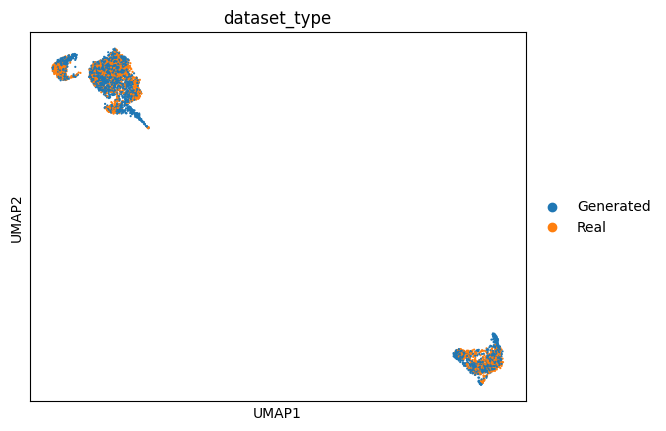

In [8]:
sc.pl.umap(adata, color="dataset_type", s=10, save="autoencoder_test_umap_w_reg.png")